In [ ]:
# SKIP THIS IF YOU WANT TO USE THE NON WEB INTERFACE (can only be done when notebook run locally)
%matplotlib inline

In [1]:
try:
    if __IPYTHON__:
        # this is used for debugging purposes only. allows to reload classes when changed
        get_ipython().magic(u'load_ext autoreload')
        get_ipython().magic(u'autoreload 2')
except NameError:       
    print('Not IPYTHON')    
    pass

import sys
import numpy as np
from time import time
from scipy.sparse import coo_matrix
import psutil
import glob
import os
import scipy
from ipyparallel import Client
#import matplotlib as mpl
#mpl.use('TkAgg')

import pylab as pl
#pl.ion()

import caiman as cm
from caiman.components_evaluation import evaluate_components
from caiman.utils.visualization import plot_contours,view_patches_bar,nb_plot_contour,nb_view_patches
from caiman.base.rois import extract_binary_masks_blob
import caiman.source_extraction.cnmf as cnmf

numba not found


In [2]:
#import bokeh.plotting as bp
import bokeh.plotting as bpl
from bokeh.models import CustomJS, ColumnDataSource, Slider
from IPython.display import display, clear_output
import matplotlib as mpl
import matplotlib.cm as cmap
import numpy as np

bpl.output_notebook()

Loading BokehJS ...

<h1> Using the workload manager SLURM </h1> 
to have an extensive use of the machine. 
<p> <em> https://slurm.schedmd.com/overview.html </em> </p>

In [3]:
# frame rate in Hz
final_frate=10 

#%%
#backend='SLURM'
backend='local'
if backend == 'SLURM':
    n_processes = np.int(os.environ.get('SLURM_NPROCS'))
else:
    n_processes = np.maximum(np.int(psutil.cpu_count()),1) # roughly number of cores on your machine minus 1
print 'using ' + str(n_processes) + ' processes'
#%% start cluster for efficient computation
single_thread=False

if single_thread:
    dview=None
else:    
    try:
        c.close()
    except:
        print 'C was not existing, creating one'
    print "Stopping  cluster to avoid unnencessary use of memory...."
    sys.stdout.flush()  
    if backend == 'SLURM':
        try:
            cm.stop_server(is_slurm=True)
        except:
            print 'Nothing to stop'
        slurm_script='/mnt/xfs1/home/agiovann/SOFTWARE/Constrained_NMF/SLURM/slurmStart.sh'
        cm.start_server(slurm_script=slurm_script)
        pdir, profile = os.environ['IPPPDIR'], os.environ['IPPPROFILE']
        c = Client(ipython_dir=pdir, profile=profile)        
    else:
        cm.stop_server()
        cm.start_server()        
        c=Client()

    print 'Using '+ str(len(c)) + ' processes'
    dview=c[:len(c)]

using 4 processes
C was not existing, creating one
Stopping  cluster to avoid unnencessary use of memory....
Stopping cluster...
NOT SLURM
No cluster to stop... done
Starting cluster...Waiting for connection file: ~/.ipython/profile_default/security/ipcontroller-client.json
......Using 4 processes


<h1> doing a F order mapping once again </h1>
<p> see : demo_pypeline.ipynb </p>
<img src="dev/kalfon/img/Fordermmap.png" /> 

In [4]:
#%% FOR LOADING ALL TIFF FILES IN A FILE AND SAVING THEM ON A SINGLE MEMORY MAPPABLE FILE
fnames=[]
base_folder='./example_movies/' # folder containing the demo files
for file in glob.glob(os.path.join(base_folder,'*.tif')):
    if file.endswith("ie.tif"):
        fnames.append(os.path.abspath(file))
fnames.sort()
print fnames  
fnames=fnames
#%%
#idx_x=slice(12,500,None)
#idx_y=slice(12,500,None)
#idx_xy=(idx_x,idx_y)
downsample_factor=1 # use .2 or .1 if file is large and you want a quick answer
final_frate=final_frate*downsample_factor
idx_xy=None
base_name='Yr'
name_new=cm.save_memmap_each(fnames, dview=dview,base_name=base_name, resize_fact=(1, 1, downsample_factor), remove_init=0,idx_xy=idx_xy )
name_new.sort()
print name_new
#%%
fname_new=cm.save_memmap_join(name_new,base_name='Yr', n_chunks=12, dview=dview)

['/Users/jeremie/CaImAn/example_movies/demoMovie.tif']
['/Users/jeremie/CaImAn/example_movies/Yr0000_d1_60_d2_80_d3_1_order_C_frames_2000_.mmap']
('/Users/jeremie/CaImAn/example_movies/Yr0000_d1_60_d2_80_d3_1_order_C_frames_2000_.mmap', 2000)
/Users/jeremie/CaImAn/example_movies/Yr_d1_60_d2_80_d3_1_order_C_frames_2000_.mmap
Deleting big mov


<h2> we are now visualizing one spatial chunks (the correlation throught time)</h2>

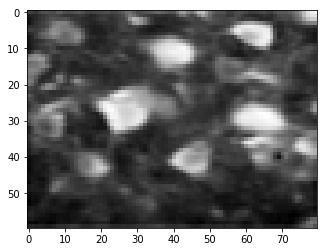

In [6]:
#%%
Yr,dims,T=cm.load_memmap(fname_new)
Y=np.reshape(Yr,dims+(T,),order='F')
#%% visualize correlation image
Cn = cm.local_correlations(Y)
pl.imshow(Cn,cmap='gray') 
pl.show()

<h2> Preprocessing of the datas and initialization of the components </h2>

In [7]:
#%% parameters of experiment
K=30 # number of neurons expected per patch
gSig=[7,7] # expected half size of neurons
merge_thresh=0.8 # merging threshold, max correlation allowed
p=2 #order of the autoregressive system
options = cnmf.utilities.CNMFSetParms(Y,n_processes,p=p,gSig=gSig,K=K,ssub=2,tsub=2, normalize_init=True)
#%% PREPROCESS DATA AND INITIALIZE COMPONENTS
t1 = time()
Yr,sn,g,psx = cnmf.pre_processing.preprocess_data(Yr,dview=dview,**options['preprocess_params'])
print time() - t1
#%%
t1 = time()
Atmp, Ctmp, b_in, f_in, center=cnmf.initialization.initialize_components(Y, **options['init_params'])                                                    
print time() - t1

using 4 processes
using 1000 pixels per process
using 1000 block_size
checking if missing data
Running on 4 engines.
0.87566781044
Noise Normalization
Spatial Downsampling ...
Roi Extraction...
Refining Components...
1.07674193382


/Users/jeremie/anaconda2/envs/CaImAn/lib/python2.7/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


<h2> creating the initial cnmf values by refining the components </h2>


In [ ]:
refine_components=False
if refine_components:
    Ain,Cin = manually_refine_components(Y,options['init_params']['gSig'],coo_matrix(Atmp),Ctmp,Cn,thr=0.9)
else:
    Ain,Cin = Atmp, Ctmp

In [ ]:
pl.close('all')

In [ ]:
p1=nb_plot_contour(Cn,Ain,dims[0],dims[1],thr=0.9,face_color=None, line_color='black',alpha=0.4,line_width=2)
bpl.show(p1)

In [ ]:
#%% UPDATE SPATIAL COMPONENTS
pl.close()
t1 = time()
A,b,Cin,f_in = cnmf.spatial.update_spatial_components(Yr, Cin, f_in, Ain, sn=sn, dview=dview,**options['spatial_params'])
t_elSPATIAL = time() - t1
print t_elSPATIAL 
#clear_output(wait=True)
print('DONE!')

In [ ]:
pl.figure(num=None, figsize=(9, 7), dpi=100, facecolor='w', edgecolor='k')
crd = plot_contours(A,Cn,thr=0.9)
pl.show()

In [ ]:
pl.close('all')

In [ ]:
p1=nb_plot_contour(Cn,A.todense(),dims[0],dims[1],thr=0.9,face_color=None, line_color='black',alpha=0.4,line_width=2)
bpl.show(p1)

In [ ]:
pl.close()
t1 = time()
options['temporal_params']['p'] = 0 # set this to zero for fast updating without deconvolution
C,A,b,f,S,bl,c1,neurons_sn,g,YrA = cnmf.temporal.update_temporal_components(Yr,A,b,Cin,f_in,bl=None,c1=None,sn=None,g=None,**options['temporal_params'])
t_elTEMPORAL = time() - t1
print t_elTEMPORAL  
clear_output(wait=True)

In [ ]:
#%% merge components corresponding to the same neuron
t1 = time()
A_m,C_m,nr_m,merged_ROIs,S_m,bl_m,c1_m,sn_m,g_m=cnmf.merging.merge_components(Yr,A,b,C,f,S,sn,options['temporal_params'], options['spatial_params'],dview=dview, bl=bl, c1=c1, sn=neurons_sn, g=g, thr=merge_thresh, mx=50, fast_merge = True)
t_elMERGE = time() - t1
print t_elMERGE

In [ ]:
#refine spatial and temporal components
pl.close()
t1 = time()
A2,b2,C2,f = cnmf.spatial.update_spatial_components(Yr, C_m, f, A_m, sn=sn,dview=dview, **options['spatial_params'])
options['temporal_params']['p'] = p # set it back to original value to perform full deconvolution
C2,A2,b2,f2,S2,bl2,c12,neurons_sn2,g21,YrA = cnmf.temporal.update_temporal_components(Yr,A2,b2,C2,f,dview=dview, bl=None,c1=None,sn=None,g=None,**options['temporal_params'])
clear_output(wait=True)
print time() - t1 # 100 seconds
print('DONE!')

In [ ]:
tB = np.minimum(-2,np.floor(-5./30*final_frate))
tA = np.maximum(5,np.ceil(25./30*final_frate))
Npeaks=10
traces=C2+YrA
#        traces_a=traces-scipy.ndimage.percentile_filter(traces,8,size=[1,np.shape(traces)[-1]/5])
#        traces_b=np.diff(traces,axis=1)
fitness_raw, fitness_delta, erfc_raw, erfc_delta, r_values, significant_samples = \
    evaluate_components(Y, traces, A, C, b, f, final_frate, remove_baseline=True,
                                      N=5, robust_std=False, Athresh=0.1, Npeaks=Npeaks,  thresh_C=0.3)
    
idx_components_r=np.where(r_values>=.6)[0]
idx_components_raw=np.where(fitness_raw<-60)[0]        
idx_components_delta=np.where(fitness_delta<-20)[0]   


min_radius=gSig[0]-2
masks_ws,idx_blobs,idx_non_blobs=extract_binary_masks_blob(
A2.tocsc(), min_radius, dims, num_std_threshold=1, 
minCircularity= 0.6, minInertiaRatio = 0.2,minConvexity =.8)




idx_components=np.union1d(idx_components_r,idx_components_raw)
idx_components=np.union1d(idx_components,idx_components_delta)  
idx_blobs=np.intersect1d(idx_components,idx_blobs)   
idx_components_bad=np.setdiff1d(range(len(traces)),idx_components)
clear_output(wait=True)
print(' ***** ')
print len(traces)
print(len(idx_components))
print(len(idx_blobs))

In [ ]:
fg=pl.figure(figsize=(12,20))
pl.subplot(1,3,1)
crd = plot_contours(A2.tocsc()[:,idx_components],Cn,thr=0.9)
pl.subplot(1,3,2)
crd = plot_contours(A2.tocsc()[:,idx_blobs],Cn,thr=0.9)
pl.subplot(1,3,3)
crd = plot_contours(A2.tocsc()[:,idx_components_bad],Cn,thr=0.9)
print dims

In [ ]:
p2=nb_plot_contour(Cn,A2.tocsc()[:,idx_components].todense(),dims[0],dims[1],thr=0.9,face_color='purple', line_color='black',alpha=0.3,line_width=2)
bpl.show(p2)

In [ ]:
traces_fluo=nb_view_patches(Yr,A2.tocsc()[:,idx_components].todense(),C[idx_components],b2,f2,dims[0],dims[1],thr = 0.9,image_neurons=None)

In [ ]:
#%% STOP CLUSTER
cm.stop_server()